In [1]:
# Prepare packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# Define the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [117]:
# Prepare data
# Load the training set
X_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-labels-idx1-ubyte')

# Load the test set
X_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-labels-idx1-ubyte')

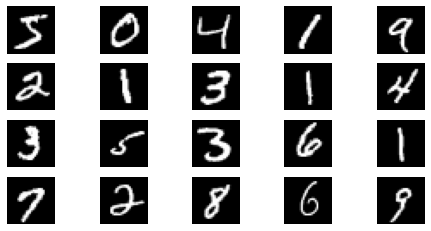

In [4]:
# Display 20 images from train_x
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_train[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

In [44]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

        
# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
# Define my loss function
class JointLoss(nn.Module):
    def __init__(self):
        super(JointLoss, self).__init__()

    def forward(self, inputs, labels):
        labels_oh = F.one_hot(labels, num_classes=10).float()
        loss = F.mse_loss(inputs, labels_oh)
        return loss

## Test different parameters 

The model performs better when implementing the CrossEntropyLoss, showing a stronger robustness towards corrupted images than using the MSELoss.

In [204]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets', train=True, transform=transforms.Compose([
            transforms.ToTensor()
        ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets', train=False, transform=transforms.Compose([
            transforms.ToTensor()
        ])),
    batch_size=1000, shuffle=False)


# Set up model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
# criterion = JointLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [205]:
# Summary for the CNN model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [247]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        # loss = criterion(output, F.one_hot(labels, num_classes=10).float())
        
        #Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/938], Loss: 0.0003
Epoch [1/10], Step [200/938], Loss: 0.0008
Epoch [1/10], Step [300/938], Loss: 0.0000
Epoch [1/10], Step [400/938], Loss: 0.0000
Epoch [1/10], Step [500/938], Loss: 0.0006
Epoch [1/10], Step [600/938], Loss: 0.0002
Epoch [1/10], Step [700/938], Loss: 0.0067
Epoch [1/10], Step [800/938], Loss: 0.0000
Epoch [1/10], Step [900/938], Loss: 0.0000
Epoch [2/10], Step [100/938], Loss: 0.0001
Epoch [2/10], Step [200/938], Loss: 0.0000
Epoch [2/10], Step [300/938], Loss: 0.0001
Epoch [2/10], Step [400/938], Loss: 0.0003
Epoch [2/10], Step [500/938], Loss: 0.0000
Epoch [2/10], Step [600/938], Loss: 0.0000
Epoch [2/10], Step [700/938], Loss: 0.0000
Epoch [2/10], Step [800/938], Loss: 0.0017
Epoch [2/10], Step [900/938], Loss: 0.0000
Epoch [3/10], Step [100/938], Loss: 0.0000
Epoch [3/10], Step [200/938], Loss: 0.0000
Epoch [3/10], Step [300/938], Loss: 0.0000
Epoch [3/10], Step [400/938], Loss: 0.0002
Epoch [3/10], Step [500/938], Loss: 0.0002
Epoch [3/10

In [248]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %.2f%%' % (100 * correct / total))

Accuracy: 99.27%


## Test on different types of noise

In [249]:
accuracy = []

correct = 0
total = 0
X_test1 = torch.from_numpy(np.reshape(X_test.copy(), (10000, 1, 28, 28))).to(torch.float32)
y_test1 = torch.from_numpy(y_test.copy()).to(torch.int64)
X_t1 = torch.utils.data.DataLoader(MyDataset(X_test1 / 255, y_test1), batch_size=1000, shuffle=False)
with torch.no_grad():
    for data in X_t1:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

Accuracy: 99.27%


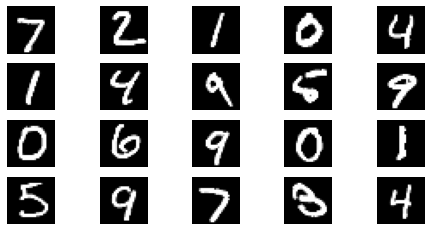

Accuracy: 66.73%


In [250]:
transform=transforms.Compose([
            transforms.ToTensor()
        ])
X_test2 = np.load('../datasets/mnist_c/brightness/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/brightness/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

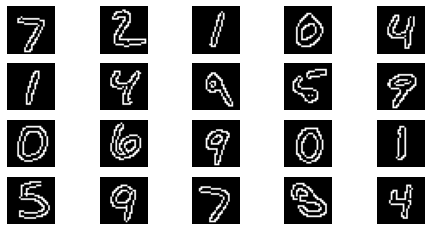

Accuracy: 69.46%


In [251]:
X_test2 = np.load('../datasets/mnist_c/canny_edges/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/canny_edges/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

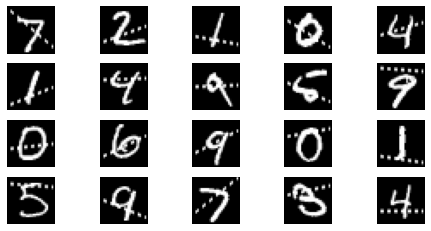

Accuracy: 98.07%


In [252]:
X_test2 = np.load('../datasets/mnist_c/dotted_line/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/dotted_line/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

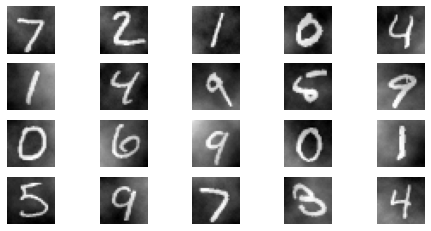

Accuracy: 34.39%


In [253]:
X_test2 = np.load('../datasets/mnist_c/fog/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/fog/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

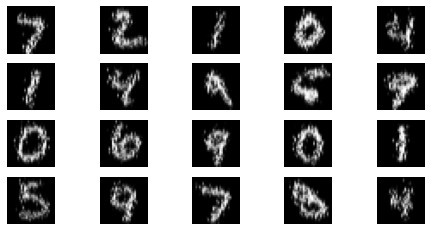

Accuracy: 90.20%


In [254]:
X_test2 = np.load('../datasets/mnist_c/glass_blur/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/glass_blur/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

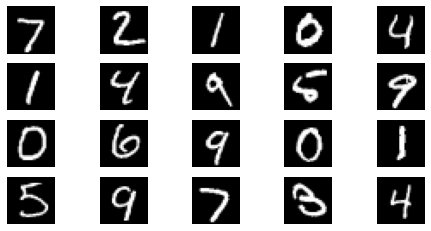

Accuracy: 99.27%


In [255]:
X_test2 = np.load('../datasets/mnist_c/identity/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/identity/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

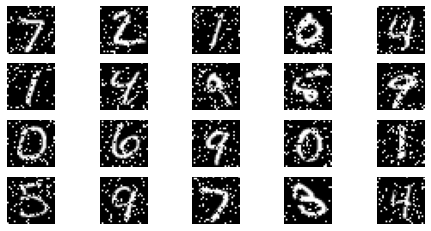

Accuracy: 83.49%


In [256]:
X_test2 = np.load('../datasets/mnist_c/impulse_noise/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/impulse_noise/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

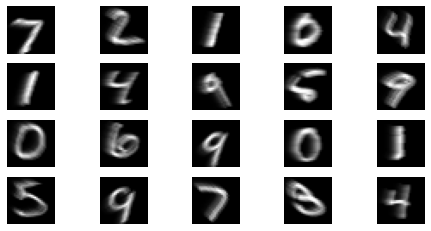

Accuracy: 93.34%


In [257]:
X_test2 = np.load('../datasets/mnist_c/motion_blur/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/motion_blur/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

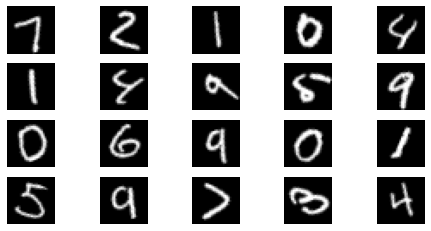

Accuracy: 94.33%


In [258]:
X_test2 = np.load('../datasets/mnist_c/rotate/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/rotate/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

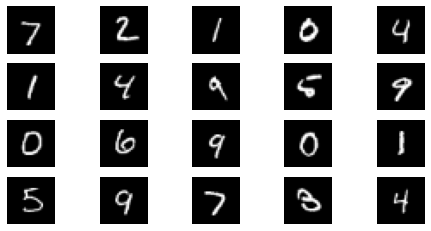

Accuracy: 94.19%


In [259]:
X_test2 = np.load('../datasets/mnist_c/scale/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/scale/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

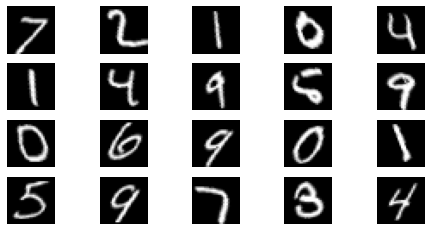

Accuracy: 97.37%


In [260]:
X_test2 = np.load('../datasets/mnist_c/shear/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/shear/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

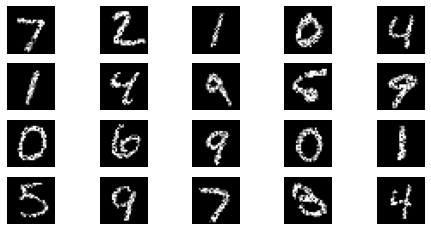

Accuracy: 96.42%


In [261]:
X_test2 = np.load('../datasets/mnist_c/shot_noise/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/shot_noise/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

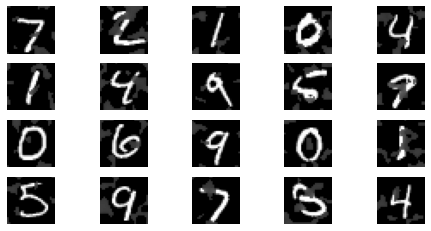

Accuracy: 97.88%


In [262]:
X_test2 = np.load('../datasets/mnist_c/spatter/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/spatter/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

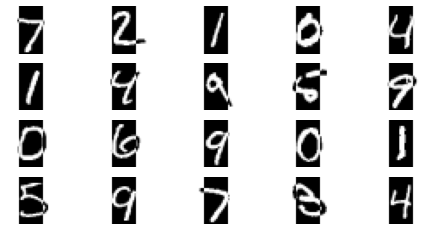

Accuracy: 82.17%


In [263]:
X_test2 = np.load('../datasets/mnist_c/stripe/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/stripe/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

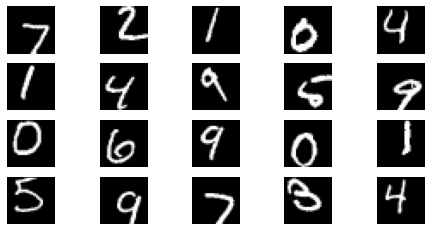

Accuracy: 57.40%


In [264]:
X_test2 = np.load('../datasets/mnist_c/translate/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/translate/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

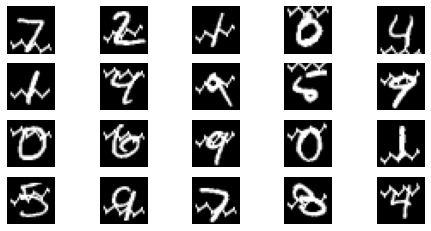

Accuracy: 85.07%


In [265]:
X_test2 = np.load('../datasets/mnist_c/zigzag/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/zigzag/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2 / 255, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

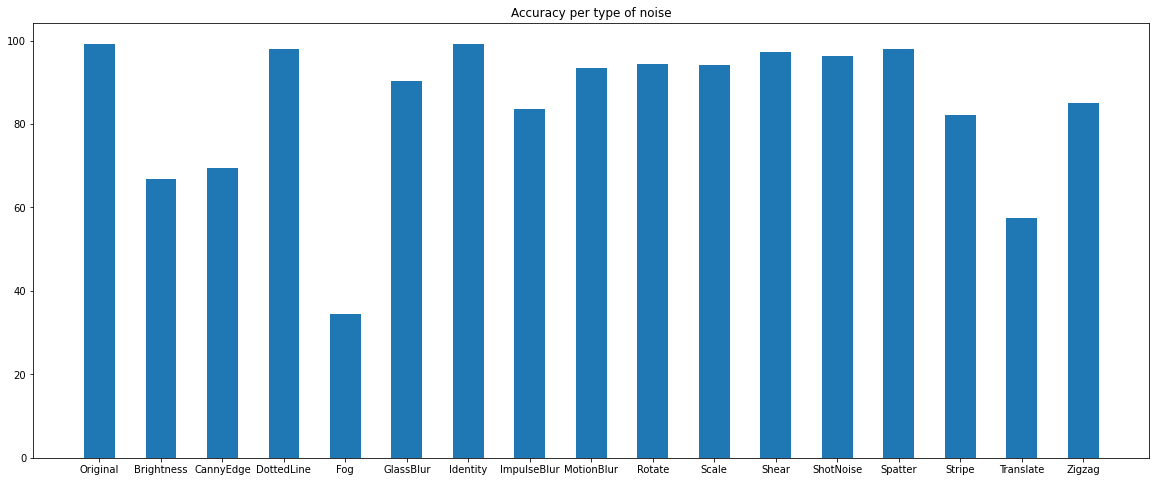

In [266]:
fig = plt.figure(figsize=(20, 8))
plt.bar(np.arange(len(accuracy)), accuracy, width=0.5)
plt.xticks(range(len(accuracy)), ['Original', 'Brightness', 'CannyEdge', 'DottedLine', 'Fog', 
                                  'GlassBlur', 'Identity', 'ImpulseBlur', 'MotionBlur', 'Rotate',
                                 'Scale', 'Shear', 'ShotNoise', 'Spatter', 'Stripe', 'Translate',
                                 'Zigzag'])
plt.title('Accuracy per type of noise')
plt.show()